<p align="justify">
Los algoritmos de optimización por gradiente descendente son cada vez más populares, y a menudo son utilizados como cajas negras con explicaciones prácticas de sus fortalezas y sus debilidades. El objetivo de este artículo es proporcionarle al lector los conocimientos mínimos en matemáticas para entender mejor el comportamiento de estos algoritmos y tener criterios sólidos para ponerlos en uso. En el curso de esta descripción general, estudiaremos las diferentes variantes de los gradientes descendentes y sus principales desafios. 
</p>

## Teoría
### Preliminares
<p align="justify">
El aprendizaje mecánico y la estadística comparten importantes características, pero usan una terminología diferente. En estadística, la regresión lineal se utiliza para modelar la relación $\mathcal{R}\subseteq\mathcal{X}\times\mathcal{Y}$ a partir  de una muestra de datos $S\subset \mathcal{R}\subseteq\mathcal{X}\times\mathcal{Y}\subseteq\mathbb{R}^{m+1}\times\mathbb{R}$. Usualmente los datos que provienen de $\mathcal{X}$ se denominan <em>variables independientes</em> y los que provienen de $\mathcal{Y}$ se denominan <em>variables dependientes</em>. En el contexto del aprendizaje mecánico, este es llamado un <em>problema de aprendizaje supervisado</em>. El conjunto $S=\{(x_i, y_i)\}_{i=0}^{k}$ se denomina <em>conjunto de entrenamiento</em>, el par de valores $(x_i, y_i)$ es un <em>ejemplo de entrenamiento</em> de un conjunto $S$ de $k$ ejemplos de entrenamiento.

Cada $x_i$ es considerado como un vector columna de la forma $x_i=(1, x_{i,1},\dots,x_{i,m})^{\top}$ de dimensión $m+1$, a menudo es referido como el predictor en la literatura estadística. El proposito de la regresión lineal es identificar el mejor <em>predictor</em> de la clase de predictores de la forma $y =\theta^{\top} x$, donde $\theta \in \mathbb{R}^{m+1}$ y es de la forma $\theta =(\theta_0, \dots, \theta_m)^\top$, el coeficiente $\theta_0$ se denomina <em>bias</em>. Para hacer esto, se considera la matriz $X\in M_{k\times m+1}(\mathbb{R})$ donde la $i$ - ésima fila está dada por el $i$ - ésimo vector fila $x_i^{\top}$. De esta manera se obtiene una expresión general para predecir los valores de $\mathcal{Y}$ que viene dada por el modelo   

\begin{equation}
Y=X\theta.
\end{equation} 

En Python podemos definir la clase de predictores $y =\theta^{\top} x$ de la siguiente forma:
</p>

In [1]:
import numpy as np

class LinearPredictor(object):
    
    def __init__(self, m: int):
        # The coefficient vector is initialized to zero.
        self.theta = np.zeros(m + 1).reshape(-1, 1)
        
    def predict(self, x: list) -> float:
        # We define theta as self.theta.
        theta = self.theta        
        # Convert «x list» to a column vector.
        x = np.array(x).reshape(-1, 1)
        
        # Returns the product of the matrices theta and x.
        return float(theta.T.dot(x))

<p align="justify">
Observe que en el código anterior, el vector de coeficientes $\theta$ se inicializó en cero, el objetivo será ir actualizandolo hasta encontrar el mejor de ellos. El problema de encontrar el mejor predictor lineal se resuelve eligiendo algún vector de coeficientes $\theta$ que minimizan la suma residual de cuadrados. Esto es equivalente a  escoger algun  vector $\hat{\theta}\in ERM_{\theta}(S)$ que sea solución del problema de optimización sin restricciones con respecto a el vector $\theta$:

<a id='1'></a>
\begin{equation}\tag{1}
ERM_{\theta}(S)\equiv \operatorname*{argmin\,\,}_{ \theta \in \mathbb{R}^{m+1}} E_{S}(\theta),
\end{equation}
donde la función de perdida relativa al conjunto de entrenamiento $S$ es:
\begin{equation}
E_S(\theta)=(Y-X\theta)^\top (Y-X\theta).
\end{equation}
En la ecuación anterior, $Y$ es el vector columna  donde la $i$ - ésima entrada está dada por cada la $y_i$ etiqueta definida en el conjunto de entrenamiento $S$, es decir, $Y = (y_1,\dots, y_k)^\top$.

Para estudios de simulación, se puede construir un modelo sintético a partir de la generación de datos con: 

<a id='2'></a>
\begin{equation}\tag{2}
Y=X\xi + \epsilon,
\end{equation} 

donde $\epsilon\sim \mathcal{N}(0, \sigma^2I_{k})$.    
</p>
<p align="justify">
    Esto se pueden implementar fácilmente en Python de la siguiente forma:
</p>

In [2]:
class SyntheticDataLinearPredictor(object):

    def __init__(self, m_dimension: int,):
        # Dimensión of the data.
        self.m = m_dimension
        
        # The vector of coefficients is chosen at random.
        self.xi = np.random.rand(m_dimension + 1).reshape(-1, 1)        
          
    def generate(self, size_data: int, sigma: float=0.5) -> tuple:
        # A column vector of ones is constructed.
        ones = np.ones(size_data).reshape(-1, 1)
        
        # Random data is generated and added to the ones vector.
        X = np.hstack((ones, np.random.rand(size_data, self.m)))
        
        # Random noise is generated.
        epsilon = sigma * np.random.standard_normal(size_data)
        
        # Values for y are constructed.
        y = X.dot(self.xi) + epsilon.reshape(-1, 1)

        return X, y, self.xi

Si $r$ denota el número de simulaciones, entonces

\begin{equation}
    S_{l}=\{X_{l}, Y_{l}\}, 
\end{equation}    

donde $l\in[r]_{\mathbb{N}_0}$. En Python podemos hacer una implementación sencilla para generar estos lotes de datos, esto sería algo así:

In [3]:
def generate_batches_simulated_data(m_dimension: int, size_data: int, n_batch: int, sigma: float=0.5) -> list:
    
    synthetic_data = SyntheticDataLinearPredictor(m_dimension)
    batches = [synthetic_data.generate(size_data, sigma) for _ in range(n_batch)]
    
    return batches

El objetivo de la ecuación [Ecuación 1](#1)es encontrar un vector $\hat{\theta}\in ERM_{\theta}(S)$ , esto se traduce en estimar el vector $\hat{\theta}$ tan cerca como sea posible al parámetro conocido $\xi$ del modelo simulado en la [Ecuación 2](#2).

El indicador para comparar una estimación de los coeficientes $\hat{\theta}$ con los coeficientes verdaderos $\xi$ es el error cuadrático medio (RMSE). Esta medición se utilizará para evaluar el rendimiento en cada una de la simulaciones $S_l$. Tenga en cuenta que el RMSE se calculan para un elemento específico en el vector $\theta$. La notación $\operatorname{RMSE}_d$ enfatizarán a qué parámetro se refiere. Para los parámetros $d\in [m]_{\mathbb{N_0}}$, considere 

\begin{equation}
\operatorname{RMSE}_d = \left(\frac{1}{r}\sum_{j=0}^{r}\big(\theta^{(d)}_j-\xi^{(d)}\big)^{2}\right)^{\frac{1}{2}}.
\end{equation}

Así se obtiene $\operatorname{RMSE} = (\operatorname{RMSE}_0,\dots, \operatorname{RMSE}_{m})$. En Python se tendría algo así:

In [4]:
def RMSE(matrix_theta: list, xi: list, number_of_simulations: int) -> np.array:
    
    matrix_theta = np.array(matrix_theta)
    xi = np.array(xi).reshape(-1, 1)
    arg = 1/number_of_simulations * (matrix_theta - xi)**2
    return np.sqrt(arg.sum(axis=1))

En el código anterior se espera como parámetro de entrada una matriz $\Theta$ donde cada $l$ - ésima columan es el $l$ - vector de coeficientes aprendido para la $l$ - ésima simulación de datos $X_{l}$, esto se explicará con más detalle a continuación.

Si se asume que $h_{\theta}$ es un predictor para el conjunto de datos $S_{l}=\{X_{l}, y_{l}\}$, entonces el problema de regresión lineal en la [Ecuación 1](#1) se puede reescribir con la siguiente función de perdida:

\begin{equation}\tag{3}
E_{S}(\theta)=\frac{1}{2k}\sum_{i=1}^{k}\big(h_{\theta}(x_i)-y_i\big)^2.
\end{equation}

Esta función para la perdida es facil de implementar en Python como podemos ver a continuación:

In [5]:
def empirical_error(predictor, sample: tuple) -> float:
    arg = list()
    size_data = len(sample[0])
    for i in range(size_data):
        x_i = sample[0][i]
        y_i = sample[1][i]
        k = len(sample[0])
        arg.append((predictor.predict(x_i) - y_i)**2)
    return 1/(2*size_data) * sum(arg) 

Una forma de resolver este problema es utilizar los métodos del gradiente descente. Estos son algoritmos que hacen uso de las derivadas parciales de funciones direfenciales convexas y, como cualquier algoritmo, su eficiencia puede ser monitoreada. Principalmente, la eficiencia de un algoritmo depende de que tan precisa es la estimación que produce. En segungo lugar, se analiza su capacidad para producir tal estimación dentro de un marco de tiempo factible.

Los métodos del gradiente descendente produce secuencias finitas de números $\theta$. Para ser eficiente esta secuencia debería converger al valor óptimo. En esta tesis, para algún $\delta > 0$, la eficacia de un algoritmo se evalúa midiendo la duración para producir una estimación $\hat{\theta}$ con precisión $\delta$ tal que:

\begin{equation}
||\hat{\theta}-\xi||<\delta
\end{equation}

En lugar de una respuesta continua $y$, la respuesta podría ser binaria, es decir, $y \in \{0, 1\}$. En estadística, este es un modelo de regresión logística. Dados ciertos predictores, también es un problema de aprendizaje supervisado. Las premisas para resolver un problema de regresión logística son similares a las de un problema continuo. En el caso binario el problema se resuelve para la siguiente función de perdida:
<a id='4'></a>
\begin{equation}\tag{4}
E_{S}(\theta) = \frac{1}{m}\bigg(\sum_{i=1}^{m}\Big(y_i\log h_{\theta}\big(x_i\big) + \big(1-y_i\big)\log \big(1 - h_{\theta}\big(x_i\big)\big)\Big)\bigg)
\end{equation}

donde

\begin{equation}
h_{\theta}(x) = \frac{1}{1+e^{-\theta^\top x}}
\end{equation}

Esta es una función convexa y suave. Por lo tanto, el proceso de solución es similar al de [Ecuación 1](#1). Pero aquí, la variable dependiente $y$ es categórica. Si $y$ tiene más de dos resultados posibles, el modelo se llama regresión logística multinomial.

### Gradiente descendente (GD)
Calcular la solución del objetivo de optimización se logra minimizando la función de costo $E_{S}(\theta)$. Su gradiente se representa por $\nabla E_{S}(\theta)$ y revela en cual direción la función decrese más rápido. Utilizando $\nabla E_{S}(\theta)$ es posible dar pasos repetidamente hacia un mínimo local. Esto sugiere el siguiente algoritmo: 

<blockquote>
    
---    
<h4>Algoritmo 1. Gradiente Descendente</h4>
    
---
**Procedure:** GRADIENT_DESCENT
<br>**Input:** $\theta$, $X$, $Y$, $I_{max}$, $ \alpha$, $\nabla E_{S}$
<br>&nbsp; &nbsp;&nbsp;**for** $k=0$ **to** $I_{max}$ **do**:
<br>&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$\theta\leftarrow \theta - \alpha \nabla E_{S}(\theta, X, Y)$
<br>&nbsp; &nbsp;&nbsp;**end**    
**return:** $\theta$
<br>**End Procedure:** GRADIENT_DESCENT
    
---
</blockquote>

En el seudocódigo anterior se tiene que $I_{max}$ es el número máximo de iteraciones y $\alpha$  es la tasa de aprendizaje, hiperparámetros que son ajustados manualmente. Hay métodos que  permite aproximar la tasa de aprendizaje  para acelerar la convergencia, pero aquí en nuestro caso,  el descenso del gradiente se mantendrá en su forma pura. Cuando $\alpha$ se elige lejos de su valor óptimo $\alpha^*$, el algoritmo divergerá si $\alpha > \alpha^*$ y convergerá muy lentamente si $\alpha < \alpha^*$. 

Recordemos la función objetivo $E(\theta)$ en [Ecuación 1](#1). Sea

\begin{equation}
h_{\theta}(x)= \theta^\top x
\end{equation}

Si el número de ejemplos de entrenamiento es $k$, el número de parámetros es $m+1$, entonces entonces considerando $j=0, \cdots, m$ y $e_0,\dots,e_m$ la base estandar, entonces el gradiente de $E_{S}(\theta)$ se puede expresar como:

\begin{equation}
\nabla E_{S}(\theta) = \sum_{i=0}^{m}\frac{\partial E}{\partial \theta_{i}}e_{i}
\end{equation}

donde

\begin{equation}
\frac{\partial E_{S}}{\partial \theta_{j}}=\frac{1}{k}\sum_{i=1}^{k}\big(\theta^\top x_i-y_i\big)x_{i,j}.
\end{equation}

La convergencia del algoritmo del gradiente descendente depende de la elección precisa de la tasa de aprendizaje $\alpha$, así como del número suficiente de iteraciones $I_{max}$. Nuestro caso es un problema de optimización convexo y tomando hiperparámetros apropiados, es decir $0<\alpha <1$, el algoritmo debería converger. 

Para la [Ecuación 4](#4), el objetivo es la optimización para la regresión logística, la función de costo es otra, pero nuevamente podemos obtener el gradiente de la siguiente manera:

\begin{equation}
\frac{\partial E_{S}}{\partial \theta_{j}}=\frac{1}{k}\sum_{i=1}^{k}\big(\theta^\top x_i-y_i\big)x_{i,j}.
\end{equation}

Como la ecuación $E_{S}(\theta)$ para la regresión logistica vuelve a ser una función convexa, entonces se puede usar los algoritmos basados en el gradiente para minimizar la [Ecuación 4](#4).

A continuación se presenta la implementación del algoritmo del gradiente descendente en python  [<sup>1](#3):

In [6]:
def gd(predictor, X, Y,  max_iterations, learning_rate, gradient_of_empirical_error):
    theta = predictor.theta
    iterations = 0
    while iterations <= max_iterations:
        theta = theta - learning_rate * gradient_of_empirical_error(theta, X, Y)
        iterations += 1
    predictor.theta = theta
    return predictor

### Gradiente descendente estocástico (SGD)

Otro algoritmo para resolver problemas de optimización es la versión estocástica del gradiente descendente. En este caso en lugar de evaluar sobretodo el conjunto de entrenamiento $S$, se selecciona aleatoriamente un solo ejemplo, de manera que el gradiente estocástico sería:

\begin{equation}
\frac{\partial E_{S, i}}{\partial \theta_{i}} = (\theta^\top x_{i} -  y_{i})x_{i, j}
\end{equation}

En esta caso, cada época para el desarrollo del decenso del gradiente descendente estocástico es una ejecución a través del todo el conjunto de datos $S$. Por lo tanto, el ciclo se puede inicializar en uno y finalizará cuando se alcance el número máximo de epocas $I_{max}$. Este algoritmo tiene la siguiente esquema:

<blockquote>
    
---    
<h4>Algoritmo 2. Gradiente Descendente Estocástico</h4>
    
---
**Procedure:** STOCHASTIC_GRADIENT_DESCENT
<br>**Input:** $\theta$, $I_{max}$, $ \alpha$, $\nabla E_{S}$, $m$
<br>&nbsp;&nbsp;&nbsp;**for** $k=1$ **to** $I_{max}$ **do**:
<br>&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; **for** $i=0$ **to** $m$ **do**:
<br>&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$\theta\leftarrow \theta - \alpha \nabla E_{S, i}(\theta)$
<br>&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; **end**    
&nbsp;&nbsp;&nbsp;**end**    
**return:** $\theta$
<br>**End Procedure:** GRADIENT_DESCENT
    
---
</blockquote>

Obserce que el algoritmo 2, $m$ denota el cantidad de datos en el conjunto $m$, consecuentemente, cada epoca recorre todos los elementso de $S$. Este algoritmo tambien se aplica para resolver el problema de la regresión logística. Un implementación rápida de este algoritmo sería:

In [7]:
def sgd(initial_coefficients, max_iterations, learning_rate, sg_of_empirical_error, m):
    coefficients = initial_coefficients
    iterations = 0
    while iterations <= max_iterations:
        for i in range(m):
            coefficients = coefficients - learning_rate * sg_of_empirical_error(coefficient)[i]
        iterations += 1
    return coefficients

### Gradiente descendente estocástico por minilotes (Mini-Batch SGD)

Otro versión del gradiente descendente y que a menudo logra un mejor rendimiento que SGD y GD es ejecutar el algoritmo por pequeñas partes de los datos. Una parte de los datos se denomina minilote (Mini-batch), mientras que todo el conjunto de entrenamiento $S$ se denomina lote. Estos minilotes se generan seleccionando aleatoriamente los vectores fila de la matriz $X$. El esquema general de este algoritmo sería:

<blockquote>
    
---    
<h4>Algoritmo 3. Gradiente Descendente Estocástico por Minilotes</h4>
    
---
**Procedure:** STOCHASTIC_GRADIENT_DESCENT
<br>**Input:** $\theta$, $I_{max}$, $ \alpha$, $\nabla E_{S}$, $n$, $m$
<br>&nbsp;&nbsp;&nbsp;**for** $k=1$ **to** $I_{max}$ **do**:
<br>&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Randomly pick a mini batch $L$ of size $n$ from $[m]_{\mathbb{N}_0}$ 
<br>&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; **for** $i$ **in** $L$ **do**:
<br>&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$\theta\leftarrow \theta - \alpha \nabla E_{S, i}(\theta)$
<br>&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; **end**    
&nbsp;&nbsp;&nbsp;**end**    
**return:** $\theta$
<br>**End Procedure:** GRADIENT_DESCENT
    
---
</blockquote>

En el algoritmo 3, los minilotes son de dimension ($n\times m+1$). Dado que $n<m$, una epoca se completa más cargo que un SGD. Intuitivamente el algoritmo converge si SGD converge. 

### Simulaciones en ambientes controlados para la regresión lineal

A continuación vamos a analizar el comportamiento de los algorimos 1, 2, 3 en un ambiente controlado de regresión lineal. Para esto vamos a generar varios datos de prueba, en los cuales podemos conocer el valor de $\theta$.

In [74]:
batches = generate_batches_simulated_data(m_dimension=1, size_data=200, n_batch=30, sigma=1.3)

In [75]:
import matplotlib.pyplot as plt
def visualize_batch(batches, n):
    x = batches[n][0][:, 1]
    y = batches[n][1]
    plt.plot(x, y, '.')

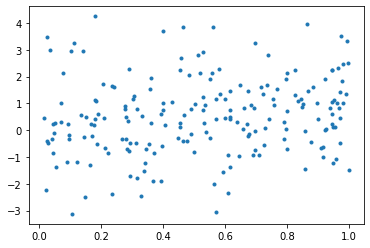

In [76]:
visualize_batch(batches, 4)

In [77]:
def euclidean_distance(theta, xi):
    arg = theta - xi
    return np.linalg.norm(arg)

In [78]:
def gd(predictor, X, Y, max_iterations, learning_rate, 
    gradient_of_empirical_error, empirical_error=None, xi=None):
    theta = predictor.theta
    delta_theta = list()
    deltas = list()
    iterations = 0
    errors = list()
    sample = tuple([X, Y])
    
    while iterations <= max_iterations:
        theta = theta - learning_rate * gradient_of_empirical_error(theta, X, Y)
        predictor.theta = theta
        
        if empirical_error is not None:            
            errors.append(empirical_error(predictor=predictor, sample=sample))
        if empirical_error is not None:
            delta_theta.append(euclidean_distance(theta, xi))
            arg = theta-xi
            deltas.append(float(arg[0]))
        iterations += 1    
    return predictor, errors, delta_theta, deltas

In [79]:
def gradient_of_empirical_error(theta, X, Y):
    return X.T.dot((X.dot(theta)- Y))

In [80]:
matrix_theta = list()
errors = list()
deltas_theta = list()
deltas = list()
xi = batches[0][2]
for batch in batches:
    X = batch[0]
    Y = batch[1]

    predictor = LinearPredictor(1)
    parameters = dict(
        predictor=predictor,
        X=X,
        Y=Y,
        max_iterations=200,
        learning_rate=0.001,
        gradient_of_empirical_error=gradient_of_empirical_error,
        empirical_error=empirical_error,
        xi=xi
    )
    predictor, error, delta_theta, delta = gd(**parameters)
    errors.append(error)
    deltas.append(delta)
    deltas_theta.append(delta_theta)
    matrix_theta.append(predictor.theta)

In [81]:
matrix_theta = np.array(matrix_theta)
matrix_theta = matrix_theta.squeeze().T

In [82]:
RMSE(matrix_theta=matrix_theta, xi=xi, number_of_simulations=30)

array([0.16899212, 0.35811964])

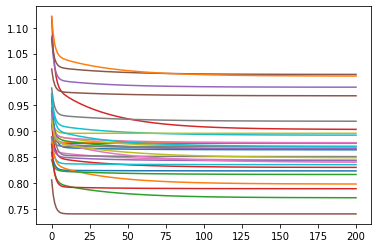

In [83]:
for error in errors:
    plt.plot(error)

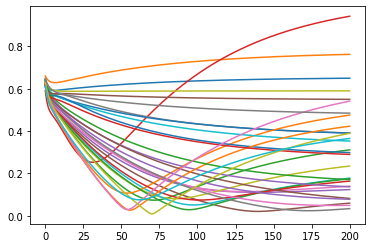

In [84]:
for delta_theta in deltas_theta:
    plt.plot(delta_theta)

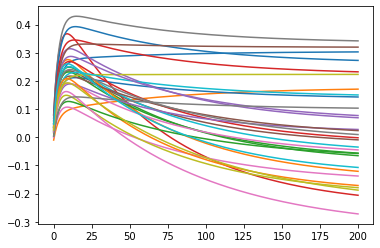

In [85]:
for delta in deltas:
    plt.plot(delta)

In [100]:
def gradient_of_empirical_error(theta, X, Y):
    return X.T.dot((X.dot(theta)- Y))

In [101]:
predictor = LinearPredictor(1)
parameters = dict(
    predictor=predictor,
    X=X,
    Y=Y,
    max_iterations=100000,
    learning_rate=0.0001,
    gradient_of_empirical_error=gradient_of_empirical_error
)
predictor = gd(**parameters)
predictor.theta

AttributeError: 'tuple' object has no attribute 'theta'

Modificaciones al algoritmo de gradiente descendente:

In [ ]:
def gd(predictor, X, Y,  max_iterations, learning_rate, gradient_of_empirical_error, empirical_error=None):
    theta = predictor.theta
    iterations = 0
    errors = list()
    sample = tuple([X, Y])
    
    while iterations <= max_iterations:
        theta = theta - learning_rate * gradient_of_empirical_error(theta, X, Y)
        predictor.theta = theta
        
        if empirical_error is not None:            
            errors.append(empirical_error(predictor=predictor, sample=sample))
        iterations += 1    
    return predictor, errors

In [ ]:
for i in [0.001, 0.0001, 0.00001, 0.000001]:
    predictor = LinearPredictor(m=1)
    parameters = dict(
        predictor=predictor,
        X=X,
        Y=Y,
        max_iterations=100,
        learning_rate=i,
        gradient_of_empirical_error=gradient_of_empirical_error,
        empirical_error=empirical_error
    )
    predictor, error = gd(**parameters)    
    plt.plot(error)
    print(predictor.theta)
    plt.show()

## Bibliografía
1. Sebastián Ruder. 2017. An overview of gradient descent optimization algorithms. Insight Centre for Data Analytics, Nui Galway.
2. https://mmuratarat.github.io/2019-01-07/logistic-regression-in-Tensorflow

## Notas
<a id="3">[1]</a>. Estos es una chimba